In [1]:
from PACE import  PACE, InMemoryBatchDataset

import os
import argparse
import numpy as np

import torch
import time


import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from scipy.stats import mannwhitneyu as mw
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
from scipy.stats import pearsonr, spearmanr

/home/ubuntu/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [9]:
def run_model(dataset, loader, repeat,model_dir, fp='GCN'):
    
    use_cuda = torch.cuda.is_available()

    if use_cuda:
        device = torch.device("cuda:%d"%(torch.cuda.current_device()))
    else:
        device = torch.device("cpu")
    
    if fp=='GCN':
        drug_dim = dataset[0][4].shape[1]
    elif fp == 'MORGAN':
        drug_dim = dataset[0][1].shape[1]
    
    lmbd=0.01
    model_fn = os.path.join( model_dir, 'PACE.model%d'%(repeat))
    model = PACE(expr_dim=dataset[0][0].shape[1], 
                 drug_dim=drug_dim, 
                 device = device, 
                 fp=fp).to(device)  
    

    model.load_state_dict(torch.load(model_fn, map_location=device))
    

    #print(model, flush=True)

    model.eval()
    preds, labels = model.predict(loader, labels=True)
    
    return preds, labels

def run(data_dir,model_dir,fp):

    res_dict = {}

    res_dict['test_pred'] = []
    res_dict['test_labels'] = []
    res_dict['samples'] = os.listdir(data_dir)
    
    dataset = InMemoryBatchDataset(data_dir)

    data_mask = np.arange(len(dataset))
    loader = [dataset[i] for i in data_mask]
    
    for i in range(10):

        res = run_model(dataset, loader, i, model_dir, fp = fp)
        res_dict['test_pred'] += [res[0]]
        res_dict['test_labels'] += [res[1]]
    
    return res_dict

def p_val_label_maker(p):
    if 5.00e-02 < p <= 1.00e+00:
        p_val_label = "ns"
    elif 1.00e-02 < p <= 5.00e-02:
        p_val_label = '*'
    elif 1.00e-03 < p <= 1.00e-02:
        p_val_label = '**'
    elif 1.00e-04 < p <= 1.00e-03:
        p_val_label = '***'
    elif p <= 1.00e-04:
        p_val_label = "****"
    return p_val_label

def create_proxy(label):
    if len(label)==1:
        ms=10
    if len(label)==2:
        ms=15
    if len(label)==3:
        ms=20
    if len(label)==4:
        ms=27
    line = matplotlib.lines.Line2D([0], [0], linestyle='none', mfc='black',
                mec='none', marker=r'$\mathregular{{{}}}$'.format(label),markersize=ms)
    return line

In [3]:
final_dict = {}
inp_dir = './data/cdr/'
model_dir = 'saved_models'
fp='GCN'

for drug in os.listdir(inp_dir):
    print('Running %s'%drug, flush=True)
    final_dict[drug] = {}
    resdict = run(os.path.join(inp_dir, drug),model_dir,fp)
    final_dict[drug] = resdict



Running bicalutamide
Running bleomycin
Running cisplatine
Running docetaxel
Running doxorubicin
Running etoposide
Running gemcitabine
Running paclitaxel
Running sorafenib
Running tamoxifen
Running temozolomide
Running vinorelbine


In [13]:
pace_n_sig = 0
pace_pval_dict = {}
drugs = final_dict.keys()
for drug in drugs:
    s = np.hstack(final_dict[drug]['test_pred']).mean(axis=1)[[final_dict[drug]['test_labels'][0]==1][0].flatten()]
    r = np.hstack(final_dict[drug]['test_pred']).mean(axis=1)[[final_dict[drug]['test_labels'][0]==0][0].flatten()]

    _, pval = mw(r, s, alternative='greater')

    pace_pval_dict[drug] = pval
    if round(pval,2)<=0.05:
        pace_n_sig+=1

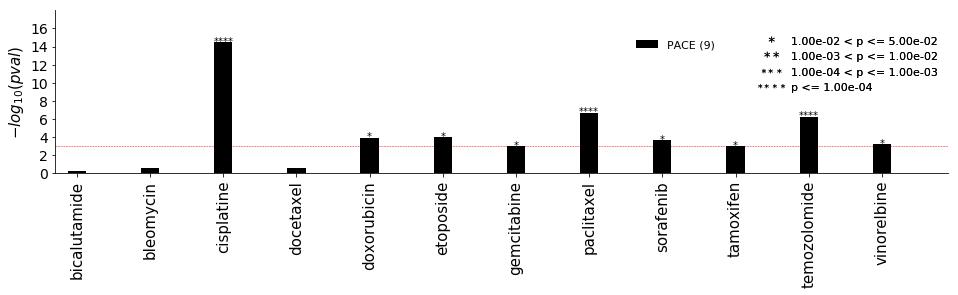

In [15]:


plt.figure(figsize=(16,3))
threshold = -1*np.log(0.05)
plt.hlines(threshold, -0.3,11.9, color='r', linestyles='dashed', zorder=0, linewidth=0.5)
for i,drug in enumerate(drugs):
    width=0.25
    
    drug_pval = pace_pval_dict[drug]
    p_val_label = p_val_label_maker(np.round(drug_pval,2))
    drug_pval = -1*np.log(drug_pval)

    plt.bar(i, drug_pval, width, label='PACE'+' (%d)'%pace_n_sig, color='black')
    if p_val_label!='ns':
        plt.text(i, drug_pval+0.1, p_val_label, fontsize=10 ,ha='center', va='center')

                

handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
legend1 = plt.legend(by_label.values(), by_label.keys(),prop={'size': 11}, frameon=False, loc=1,bbox_to_anchor=(0.75,0.88))
pval_legend_labels = ['1.00e-02 < p <= 5.00e-02','1.00e-03 < p <= 1.00e-02','1.00e-04 < p <= 1.00e-03','p <= 1.00e-04']
pval_legend_handles = [create_proxy('*'),create_proxy('**'),create_proxy('***'),create_proxy('****')]
legend2 = plt.legend(pval_legend_handles, pval_legend_labels,prop={'size': 11}, frameon=False, loc=1,bbox_to_anchor=(1,0.9))
plt.gca().add_artist(legend1)
plt.gca().add_artist(legend2)
plt.yticks(fontsize=14)
plt.xlim(-0.3,11.9)
ylim=(0,18)
plt.ylim(ylim)
plt.yticks(np.arange(ylim[0],ylim[1],2))
plt.ylabel(r'$-log_{10}(pval)$', fontsize=15)
plt.xticks(labels=drugs, ticks=np.arange(len(drugs)), rotation=90, fontsize=15)
plt.savefig('./plots/PACE_cdr.png', dpi=600)

plt.show()
plt.close()
